In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
%matplotlib inline

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from matplotlib import rcParams 
rcParams.update({'font.size': 18})

In [1]:
import tensorflow as tf
import tensorflow.python.keras.backend as K
from tensorflow.python.keras.backend import eager_learning_phase_scope

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
tf.__version__

'2.2.0'

In [3]:
import xarray as xr
import os

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Original timeseries with gaps

In [6]:
with open("../data/temp_depth_gapfilling/temp_df_245_original.pickle", "rb") as pickle_in:
    temp_df_245_wgaps = pickle.load(pickle_in).asfreq('1d')

Text(0.5, 0, 'Time (years)')

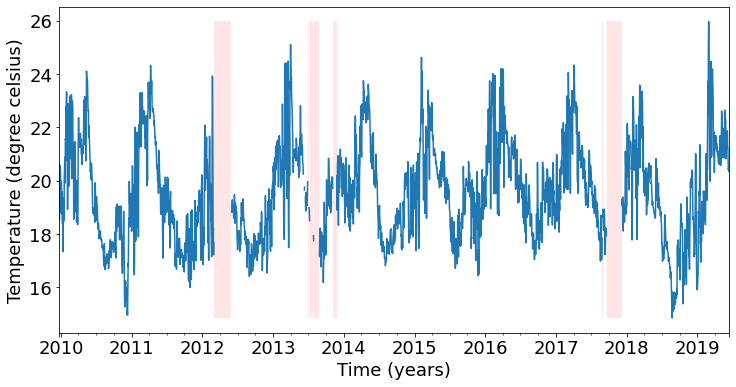

In [7]:
fig, ax = plt.subplots()
import matplotlib.transforms as mtransforms
temp_df_245_wgaps.TEMP.plot(ax = ax, figsize=(12,6))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(temp_df_245_wgaps.index, temp_df_245_wgaps.TEMP.min(), temp_df_245_wgaps.TEMP.max(), where=np.isnan(temp_df_245_wgaps.TEMP),
                facecolor='red', alpha=0.1)
plt.ylabel("Temperature (degree celsius)")
plt.xlabel("Time (years)")

Training History of final three models

In [6]:
with open("../data/temp_depth_gapfilling/bidirectional_lstm_model_hist30_targ6_loss-descaledmape_earlystopping_history.pickle", "rb") as pickle_in:
    hist1 = pickle.load(pickle_in)
with open("../data/temp_depth_gapfilling/bidirectional_lstm_model_hist30_targ30_loss-descaledmape_earlystopping_history.pickle", "rb") as pickle_in:
    hist2 = pickle.load(pickle_in)
with open("../data/temp_depth_gapfilling/MCdropout/bidirectional_lstm_model_hist91_targ91_multivariate_loss-descaledmape_history.pickle", "rb") as pickle_in:
    hist3 = pickle.load(pickle_in)

hist1["epoch"] = hist1.index + 1
hist2["epoch"] = hist2.index + 1
hist3["epoch"] = hist3.index + 1

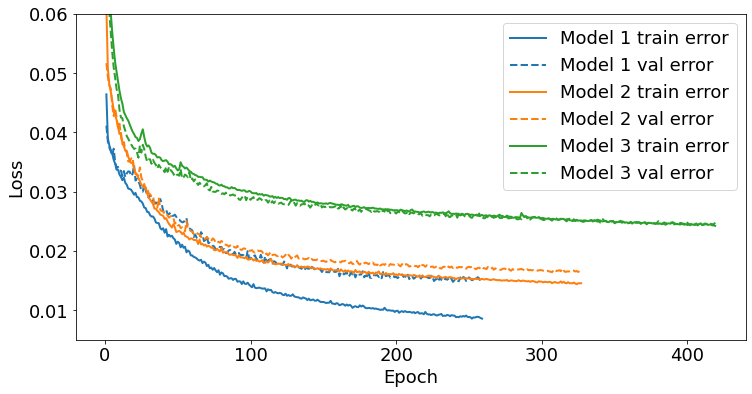

In [7]:
# Now plot training curves
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Model 1: History 30, Target 6')
line, = ax.plot(hist1['epoch'], hist1['descaled_mape'], linewidth=2,
         label = 'Model 1 train error')
plt.plot(hist1['epoch'], hist1['val_descaled_mape'], color=line.get_color(), linestyle='--', linewidth=2,
         label = 'Model 1 val error')
line, = ax.plot(hist2['epoch'], hist2['descaled_mape'], linewidth=2,
         label='Model 2 train error')
plt.plot(hist2['epoch'], hist2['val_descaled_mape'], color=line.get_color(), linestyle='--', linewidth=2,
         label = 'Model 2 val error')
line, = ax.plot(hist3['epoch'], hist3['descaled_mape'], linewidth=2,
         label='Model 3 train error')
plt.plot(hist3['epoch'], hist3['val_descaled_mape'], color=line.get_color(), linestyle='--', linewidth=2,
         label = 'Model 3 val error')
# plt.text(0.02,0.9,"(a)",transform=ax.transAxes, fontsize=30)
plt.ylim([0.005,0.06])
plt.legend()

# fig, ax = plt.subplots(figsize=(10,5))
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Model 2: History 30, Target 30')
# plt.plot(hist2['epoch'], hist2['descaled_mape'],
#          label='Train Error')
# plt.plot(hist2['epoch'], hist2['val_descaled_mape'],
#          label = 'Val Error')
# plt.text(0.02,0.9,"(b)",transform=ax.transAxes, fontsize=30)
# plt.ylim([0.005,0.06])
# plt.legend()

# fig, ax = plt.subplots(figsize=(10,5))
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Model 3: History 91, Target 91')
# plt.plot(hist3['epoch'], hist3['descaled_mape'],
#          label='Train Error')
# plt.plot(hist3['epoch'], hist3['val_descaled_mape'],
#          label = 'Val Error')
# plt.text(0.02,0.9,"(c)",transform=ax.transAxes, fontsize=30)
# plt.ylim([0.005,0.06])
# plt.legend()

# plt.show()

Sample predictions

In [10]:
class descaled_mape(keras.losses.Loss):
    """
    A loss/metric that (de)scales true and predicted values into absolute units before calculating mean absolute percentage error (mape).
    Args:
        mu: mean (usually training data mean)
        sd: standard dev (usually based on training data)
        reduction: Type of tf.keras.losses.Reduction to apply to loss.
        name: name of loss function
    """
    def __init__(self, mu, sd, reduction=keras.losses.Reduction.AUTO, name='descaled_mape'):
        super().__init__(reduction=reduction, name=name)
        self.mu=mu
        self.sd=sd
    
    def call(self, y_true, y_pred):
        y_true = y_true * self.sd + self.mu
        y_pred = y_pred * self.sd + self.mu
        return tf.math.reduce_mean(tf.abs((y_true - y_pred)/y_true))
    
def gap_loc_and_len(sample):
    tmp = 0
    loc = []
    leng = []
    for i in range(len(sample)):
        current=sample[i]
        if not(np.isnan(current)) and tmp>0:
            leng.append(tmp)
            tmp=0
        if np.isnan(current):
            if (tmp==0) : loc.append(i)
            tmp=tmp+1
    df = pd.DataFrame({'location': loc,
                       'length': leng})
    return(df)

def gapfill(samp, lstm_model, train_mean, train_std, hist_len, pred_len, gaps = pd.DataFrame()):
    if gaps.empty: gaps = gap_loc_and_len(samp.TEMP)
    for i in range(len(gaps)):
        gap_start = gaps.location[i]
        gap_length = gaps.length[i]
        hist_end = gap_start
        if gap_start < hist_len:
            hist_start = 0
        else:
            hist_start = gap_start - hist_len
        if ((gap_start >= hist_len) and (not np.any(np.isnan(samp.TEMP[hist_start: hist_end]))) and (gap_length <= pred_len)):
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(samp.TEMP.values[:gap_start][-hist_len:], (1,hist_len,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = lstm_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            samp.TEMP[gap_start : (gap_start + gap_length)] = out
    return samp

In [11]:
def create_time_steps(length):
  return list(range(-length, 0))

In [12]:
def multi_step_plot(history, true_future, prediction, lab):
  fig, ax = plt.subplots(figsize=(10, 5))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.text(0.9,0.9,lab,transform=ax.transAxes,fontsize=30)

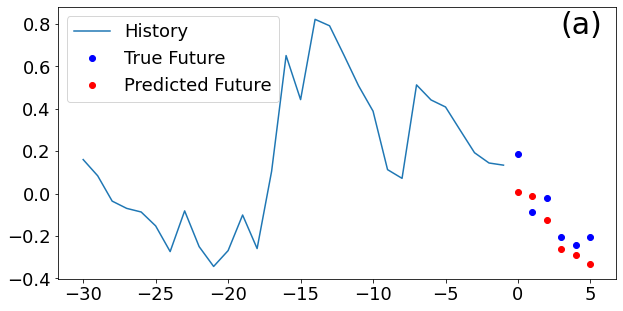

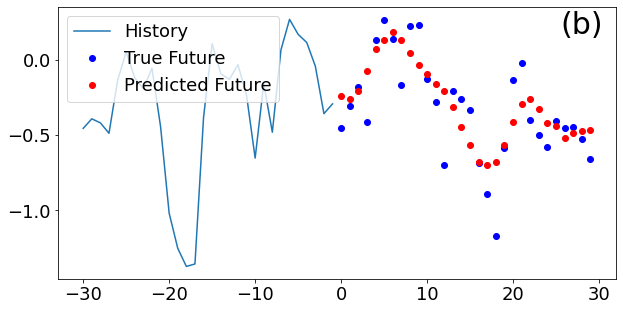

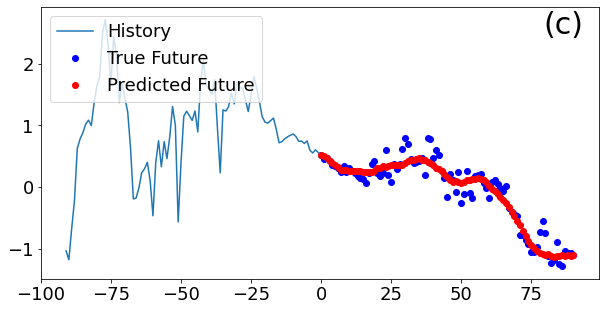

In [11]:
with open("../data/temp_depth_gapfilling/train_mean-std_train-val_data-labels_hist30_targ6.pickle", "rb") as pickle_in:
    pickle_data = pickle.load(pickle_in)
    train_mean = pickle_data[0]
    train_std = pickle_data[1]
    train_data = pickle_data[2]
    train_labels = pickle_data[3]
    val_data = pickle_data[4]
    val_labels = pickle_data[5]

#load model 3
bidirectional_lstm_targ6_model = keras.models.load_model('../data/temp_depth_gapfilling/saved_models/saved_modelsbidirectional_lstm_model_hist30_targ6_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ6_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

sample_num = random.randint(0, val_data.shape[0])
hist = (val_data[sample_num]-train_mean)/train_std
true = (val_labels[sample_num]-train_mean)/train_std
pred = bidirectional_lstm_targ6_model.predict(np.reshape(hist, (1,30,1)))
multi_step_plot(hist, true, pred[0,:], "(a)")

with open("../data/temp_depth_gapfilling/train_mean-std_train-val_data-labels_hist30_targ30.pickle", "rb") as pickle_in:
    pickle_data = pickle.load(pickle_in)
    train_mean = pickle_data[0]
    train_std = pickle_data[1]
    train_data = pickle_data[2]
    train_labels = pickle_data[3]
    val_data = pickle_data[4]
    val_labels = pickle_data[5]

#load model 3
bidirectional_lstm_targ30_model = keras.models.load_model('../data/temp_depth_gapfilling/saved_models/saved_modelsbidirectional_lstm_model_hist30_targ30_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ30_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

sample_num = random.randint(0, val_data.shape[0])
hist = (val_data[sample_num]-train_mean)/train_std
true = (val_labels[sample_num]-train_mean)/train_std
pred = bidirectional_lstm_targ30_model.predict(np.reshape(hist, (1,30,1)))
multi_step_plot(hist, true, pred[0,:], "(b)")

# with open("../data/temp_depth_gapfilling/simple/train_mean-std_train-val_data-labels_hist91_targ91.pickle", "rb") as pickle_in:
#     pickle_data = pickle.load(pickle_in)
#     train_mean = pickle_data[0]
#     train_std = pickle_data[1]
#     train_data = pickle_data[2]
#     train_labels = pickle_data[3]
#     val_data = pickle_data[4]
#     val_labels = pickle_data[5]

# #load model 3
# bidirectional_lstm_targ91_model = keras.models.load_model('../data/temp_depth_gapfilling/simple/saved_models/bidirectional_lstm_model_hist91_targ91_loss-descaledmape.h5', compile=False)
# bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

# sample_num = random.randint(0, val_data.shape[0])
# hist = (val_data[sample_num]-train_mean)/train_std
# true = (val_labels[sample_num]-train_mean)/train_std
# pred = bidirectional_lstm_targ91_model.predict(np.reshape(hist, (1,91,1)))
# multi_step_plot(hist, true, pred[0,:], "(c)")

with open("../data/temp_depth_gapfilling/simple/train_mean-std_train-val_data-labels_hist91_targ91_multivariate.pickle", "rb") as pickle_in:
    pickle_data = pickle.load(pickle_in)
    train_mean = pickle_data[0]
    train_std = pickle_data[1]
    train_data = pickle_data[2]
    train_labels = pickle_data[3]
    val_data = pickle_data[4]
    val_labels = pickle_data[5]

#load model 3
bidirectional_lstm_targ91_model = keras.models.load_model('../data/temp_depth_gapfilling/simple/saved_models/bidirectional_lstm_model_hist91_targ91_multivariate_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

sample_num = random.randint(0, val_data.shape[0])
hist = (val_data[sample_num]-train_mean)/train_std
true = (val_labels[sample_num]-train_mean)/train_std
pred = bidirectional_lstm_targ91_model.predict(np.reshape(hist, (1,91,2)))
multi_step_plot(hist, true, pred[0,:], "(c)")


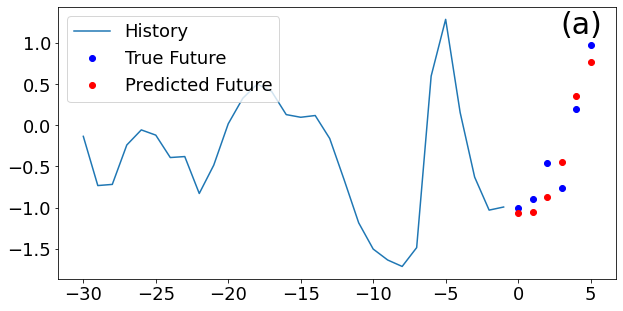

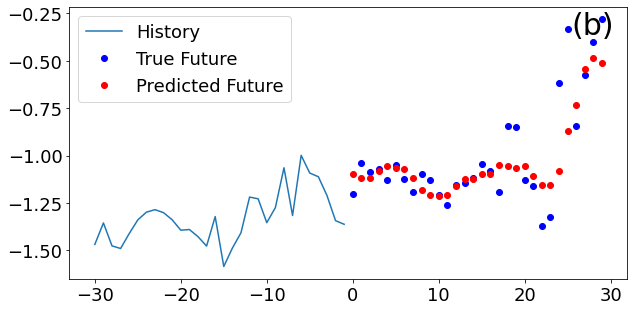

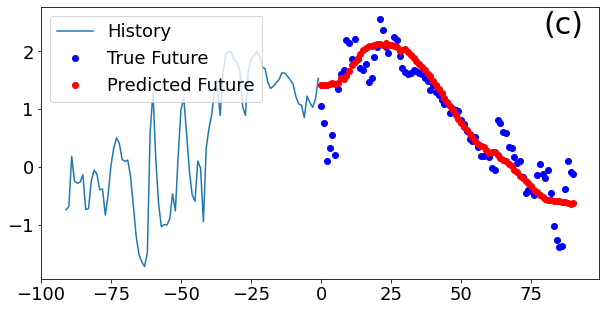

In [17]:
with open("../data/temp_depth_gapfilling/train_mean-std_train-val_data-labels_hist30_targ6.pickle", "rb") as pickle_in:
    pickle_data = pickle.load(pickle_in)
    train_mean = pickle_data[0]
    train_std = pickle_data[1]
    train_data = pickle_data[2]
    train_labels = pickle_data[3]
    val_data = pickle_data[4]
    val_labels = pickle_data[5]

#load model 3
bidirectional_lstm_targ6_model = keras.models.load_model('../data/temp_depth_gapfilling/saved_models/saved_modelsbidirectional_lstm_model_hist30_targ6_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ6_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

sample_num = random.randint(0, val_data.shape[0])
hist = (val_data[sample_num]-train_mean)/train_std
true = (val_labels[sample_num]-train_mean)/train_std
pred = bidirectional_lstm_targ6_model.predict(np.reshape(hist, (1,30,1)))
multi_step_plot(hist, true, pred[0,:], "(a)")

with open("../data/temp_depth_gapfilling/train_mean-std_train-val_data-labels_hist30_targ30.pickle", "rb") as pickle_in:
    pickle_data = pickle.load(pickle_in)
    train_mean = pickle_data[0]
    train_std = pickle_data[1]
    train_data = pickle_data[2]
    train_labels = pickle_data[3]
    val_data = pickle_data[4]
    val_labels = pickle_data[5]

#load model 3
bidirectional_lstm_targ30_model = keras.models.load_model('../data/temp_depth_gapfilling/saved_models/saved_modelsbidirectional_lstm_model_hist30_targ30_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ30_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

sample_num = random.randint(0, val_data.shape[0])
hist = (val_data[sample_num]-train_mean)/train_std
true = (val_labels[sample_num]-train_mean)/train_std
pred = bidirectional_lstm_targ30_model.predict(np.reshape(hist, (1,30,1)))
multi_step_plot(hist, true, pred[0,:], "(b)")

# with open("../data/temp_depth_gapfilling/simple/train_mean-std_train-val_data-labels_hist91_targ91.pickle", "rb") as pickle_in:
#     pickle_data = pickle.load(pickle_in)
#     train_mean = pickle_data[0]
#     train_std = pickle_data[1]
#     train_data = pickle_data[2]
#     train_labels = pickle_data[3]
#     val_data = pickle_data[4]
#     val_labels = pickle_data[5]

# #load model 3
# bidirectional_lstm_targ91_model = keras.models.load_model('../data/temp_depth_gapfilling/simple/saved_models/bidirectional_lstm_model_hist91_targ91_loss-descaledmape.h5', compile=False)
# bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

# sample_num = random.randint(0, val_data.shape[0])
# hist = (val_data[sample_num]-train_mean)/train_std
# true = (val_labels[sample_num]-train_mean)/train_std
# pred = bidirectional_lstm_targ91_model.predict(np.reshape(hist, (1,91,1)))
# multi_step_plot(hist, true, pred[0,:], "(c)")

with open("../data/temp_depth_gapfilling/simple/train_mean-std_train-val_data-labels_hist91_targ91_multivariate.pickle", "rb") as pickle_in:
    pickle_data = pickle.load(pickle_in)
    train_mean = pickle_data[0]
    train_std = pickle_data[1]
    train_data = pickle_data[2]
    train_labels = pickle_data[3]
    val_data = pickle_data[4]
    val_labels = pickle_data[5]

#load model 3
bidirectional_lstm_targ91_model = keras.models.load_model('../data/temp_depth_gapfilling/MCdropout/saved_models/bidirectional_lstm_model_hist91_targ91_multivariate_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

sample_num = random.randint(0, val_data.shape[0])
hist = (val_data[sample_num]-train_mean)/train_std
true = (val_labels[sample_num]-train_mean)/train_std
pred = bidirectional_lstm_targ91_model.predict(np.reshape(hist, (1,91,2)))
multi_step_plot(hist, true, pred[0,:], "(c)")


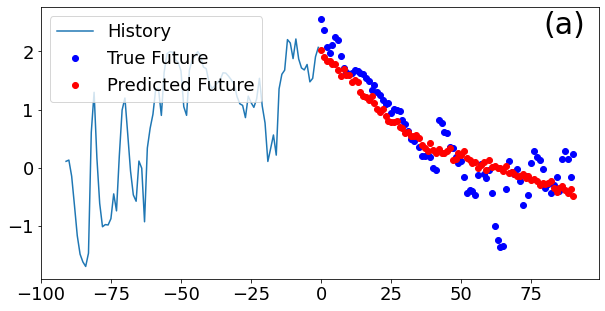

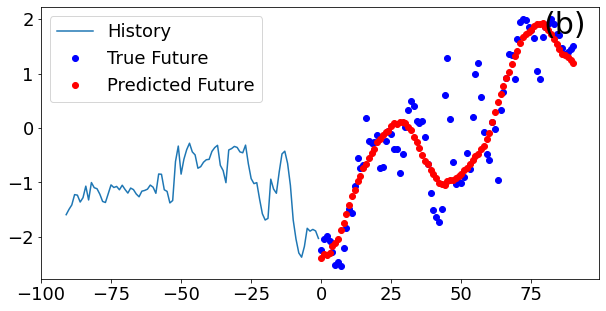

In [15]:
with open("../data/temp_depth_gapfilling/simple/train_mean-std_train-val_data-labels_hist91_targ91.pickle", "rb") as pickle_in:
    pickle_data = pickle.load(pickle_in)
    train_mean = pickle_data[0]
    train_std = pickle_data[1]
    train_data = pickle_data[2]
    train_labels = pickle_data[3]
    val_data = pickle_data[4]
    val_labels = pickle_data[5]

#load model 3
bidirectional_lstm_targ91_model = keras.models.load_model('../data/temp_depth_gapfilling/simple/saved_models/bidirectional_lstm_model_hist91_targ91_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

sample_num = random.randint(0, val_data.shape[0])
hist = (val_data[sample_num]-train_mean)/train_std
true = (val_labels[sample_num]-train_mean)/train_std
pred = bidirectional_lstm_targ91_model.predict(np.reshape(hist, (1,91,1)))
multi_step_plot(hist, true, pred[0,:], "(a)")

with open("../data/temp_depth_gapfilling/simple/train_mean-std_train-val_data-labels_hist91_targ91_multivariate.pickle", "rb") as pickle_in:
    pickle_data = pickle.load(pickle_in)
    train_mean = pickle_data[0]
    train_std = pickle_data[1]
    train_data = pickle_data[2]
    train_labels = pickle_data[3]
    val_data = pickle_data[4]
    val_labels = pickle_data[5]

#load model 3
bidirectional_lstm_targ91_model = keras.models.load_model('../data/temp_depth_gapfilling/simple/saved_models/bidirectional_lstm_model_hist91_targ91_multivariate_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

sample_num = random.randint(0, val_data.shape[0])
hist = (val_data[sample_num]-train_mean)/train_std
true = (val_labels[sample_num]-train_mean)/train_std
pred = bidirectional_lstm_targ91_model.predict(np.reshape(hist, (1,91,2)))
multi_step_plot(hist, true, pred[0,:], "(b)")


final timeseries based on final models

In [85]:
with open("../data/temp_depth_gapfilling/temp_df_245_original.pickle", "rb") as pickle_in:
    temp_df_245_wgaps = pickle.load(pickle_in).asfreq('1d')
with open("../data/temp_depth_gapfilling/final_timeseries/temp_df_245_filled_2.pickle", "rb") as pickle_in:
    temp_df_245_filled_2 = pickle.load(pickle_in)

In [86]:
with open("../data/temp_depth_gapfilling/simple/train_mean-std_train-val_data-labels_hist91_targ91_multivariate.pickle", "rb") as pickle_in:
    pickle_data = pickle.load(pickle_in)
    train_mean = pickle_data[0]
    train_std = pickle_data[1]
    train_data = pickle_data[2]
    train_labels = pickle_data[3]
    val_data = pickle_data[4]
    val_labels = pickle_data[5]

#load model 3
bidirectional_lstm_targ91_model = keras.models.load_model('../data/temp_depth_gapfilling/MCdropout/saved_models/bidirectional_lstm_model_hist91_targ91_multivariate_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

In [87]:
hist_len = 91
targ_len = 91
samp = temp_df_245_filled_2.copy()
gaps = gap_loc_and_len(samp.TEMP)
for i in range(len(gaps)):
    gap_start = gaps.location[i]
    gap_len = gaps.length[i]
    hist_before = samp.TEMP.values[(gap_start-hist_len):(gap_start), np.newaxis]
    hist_after = samp.TEMP.values[(gap_start+hist_len+gap_len-1):(gap_start+gap_len-1):-1, np.newaxis]
    hist = np.reshape(np.hstack([hist_before, hist_after]), (1, 91, 2))
    hist = (hist - train_mean)/train_std
    pred = bidirectional_lstm_targ91_model.predict(hist)
    pred = pred*train_std + train_mean
    samp.TEMP[gap_start:(gap_start+gap_len)] = pred[0,:gap_len]
temp_df_245_filled_3 = samp

In [88]:
temp_df_245 = temp_df_245_wgaps.copy()

In [89]:
temp_df_245['LSTM_pred'] = temp_df_245_filled_3.TEMP
temp_df_245['InterpTime'] = temp_df_245_wgaps.TEMP.interpolate(method='time')
temp_df_245

,TEMP,DEPTH,LSTM_pred,InterpTime
TIME,,,,
2009-12-23,19.442522,23.729443,19.442522,19.442522
2009-12-24,18.526331,23.694855,18.526331,18.526331
2009-12-25,19.328674,23.695995,19.328674,19.328674
2009-12-26,20.563595,23.792873,20.563595,20.563595
2009-12-27,20.583179,23.702913,20.583179,20.583179
...,...,...,...,...
2019-06-08,20.957422,26.174713,20.957422,20.957422
2019-06-09,20.641022,26.241486,20.641022,20.641022
2019-06-10,20.401205,26.195374,20.401205,20.401205


In [90]:
# remove predictions where there are no nans
temp_df_245.InterpTime.iloc[np.where(~np.isnan(temp_df_245.TEMP))] = np.nan
temp_df_245.LSTM_pred.iloc[np.where(~np.isnan(temp_df_245.TEMP))] = np.nan

In [121]:
def gapfilling_comp_plot(plot_df):
  plt.figure(figsize=(15, 6))

  plt.plot(plot_df.index, plot_df.TEMP, label='Gappy timeseries')
  plt.plot(plot_df.index, plot_df.InterpTime,
           label='Interpolated')
  plt.plot(plot_df.index, plot_df.LSTM_pred,
            label='LSTM predicted')
  plt.legend(loc='upper left')
  plt.ylabel("Temperature (degree celsius)")
  plt.xlabel("Time (years)")
  plt.show()

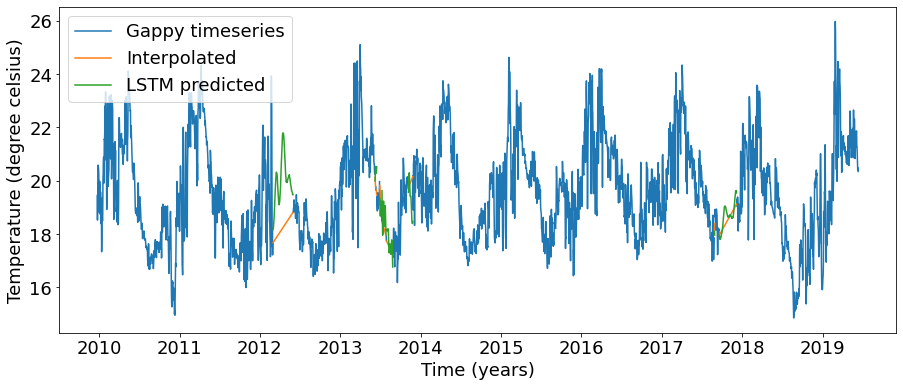

In [122]:
gapfilling_comp_plot(temp_df_245)

Text(0.5, 0, 'Time (years)')

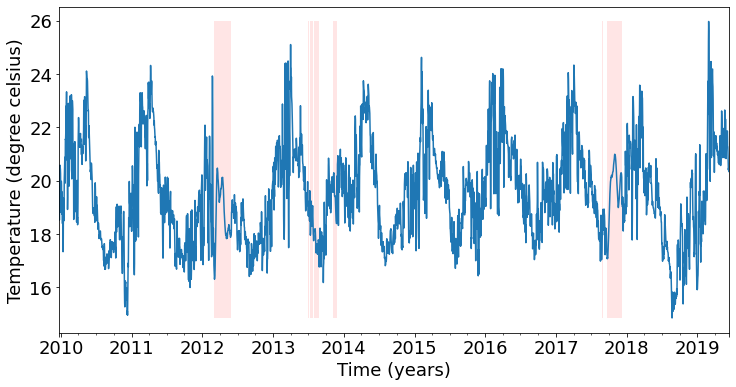

In [20]:
####################
# Below plot is based on reverse prediction using three layer model3
####################
fig, ax = plt.subplots()
import matplotlib.transforms as mtransforms
temp_df_245_filled_3.TEMP.plot(ax = ax, figsize=(12,6))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(temp_df_245_wgaps.index, temp_df_245_wgaps.TEMP.min(), temp_df_245_wgaps.TEMP.max(), where=np.isnan(temp_df_245_wgaps.TEMP),
                facecolor='red', alpha=0.1)
plt.ylabel("Temperature (degree celsius)")
plt.xlabel("Time (years)")

Plot longest two gaps with all dropout model preds to show uncertainty

In [17]:
temp_df_245

,TEMP,DEPTH,LSTM_pred,InterpTime
TIME,,,,
2009-12-23,19.442522,23.729443,NaN,NaN
2009-12-24,18.526331,23.694855,NaN,NaN
2009-12-25,19.328674,23.695995,NaN,NaN
2009-12-26,20.563595,23.792873,NaN,NaN
2009-12-27,20.583179,23.702913,NaN,NaN
...,...,...,...,...
2019-06-08,20.957422,26.174713,NaN,NaN
2019-06-09,20.641022,26.241486,NaN,NaN
2019-06-10,20.401205,26.195374,NaN,NaN


In [18]:
mcmodel = models.Model(bidirectional_lstm_targ91_model.inputs, bidirectional_lstm_targ91_model.layers[-1].output)

In [20]:
hist_len = 91
targ_len = 91
samp = temp_df_245_filled_2.copy()
gaps = gap_loc_and_len(samp.TEMP)
hist = []
for i in range(len(gaps)):
    gap_start = gaps.location[i]
    gap_len = gaps.length[i]
    hist_before = samp.TEMP.values[(gap_start-hist_len):(gap_start), np.newaxis]
    hist_after = samp.TEMP.values[(gap_start+hist_len+gap_len-1):(gap_start+gap_len-1):-1, np.newaxis]
    hist.append(np.reshape(np.hstack([hist_before, hist_after]), (1, 91, 2)))
    hist[i] = (hist[i] - train_mean)/train_std

In [83]:
mc_samples = 100
mc_pred = []
for i in range(len(gaps)):
    with eager_learning_phase_scope(value=1): # 0=test, 1=train
            mc_pred.append(np.array([mcmodel([hist[i]], training=True)[0] for _ in range(mc_samples)]).transpose())
    mc_pred[i] = mc_pred[i] * train_std + train_mean

In [91]:
mcdrop_ts = [None] * len(temp_df_245)
# mcdrop_ts[:] = np.nan
for i in range(mc_samples):
    for j in range(len(gaps)):
        mcdrop_ts[gaps.location[j]:(gaps.location[j]+gaps.length[j])] = mc_pred[j][:gaps.length[j],i]
    temp_df_245.insert(3+i, "mcdrop"+str(i), mcdrop_ts)

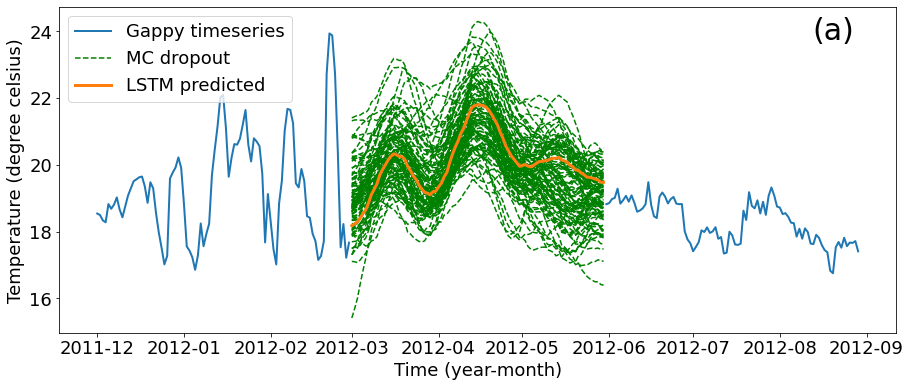

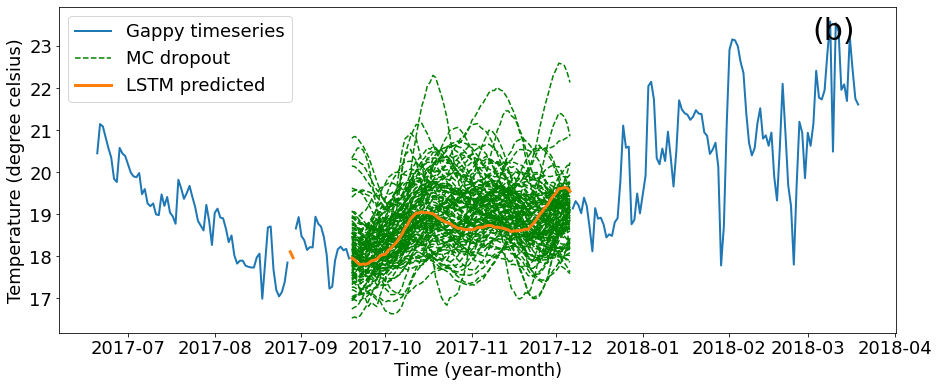

In [99]:
plot_df = temp_df_245.iloc[799-91:799+91+91]

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(plot_df.index, plot_df.TEMP, label='Gappy timeseries', linewidth=2)
plt.plot(plot_df.index, plot_df.iloc[:,-100:-1], 'g--')
plt.plot(plot_df.index, plot_df.iloc[:,3], 'g--', label="MC dropout")
plt.plot(plot_df.index, plot_df.LSTM_pred, linewidth=3,
            label='LSTM predicted')
plt.legend(loc='upper left')
plt.ylabel("Temperature (degree celsius)")
plt.xlabel("Time (year-month)")
plt.text(0.9,0.9,'(a)',transform=ax.transAxes,fontsize=30)

plot_df = temp_df_245.iloc[2827-91:2827+91+91]

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(plot_df.index, plot_df.TEMP, label='Gappy timeseries', linewidth=2)

plt.plot(plot_df.index, plot_df.iloc[:,-100:-1], 'g--')
plt.plot(plot_df.index, plot_df.iloc[:,3], 'g--', label="MC dropout")
plt.plot(plot_df.index, plot_df.LSTM_pred, linewidth=3,
            label='LSTM predicted')
plt.legend(loc='upper left')
plt.ylabel("Temperature (degree celsius)")
plt.xlabel("Time (year-month)")
plt.text(0.9,0.9,'(b)',transform=ax.transAxes,fontsize=30)

plt.show()